In [1]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
def opti_steps(m_l=0.5, k=3000, tau_max=0.05, omega_max=3000, nsteps=3, t=0.2, X_init=(0,0,0), T_guess=(0.0003, 5)):
    ''' Optimize T1 and T2 over multiple steps '''

    ''' Function for one analytical step '''
    X0 = SX.sym('X0', 3) #states
    x_a0 = X0[0]
    x_l0 = X0[1]
    v_l0 = X0[2]
    T = SX.sym('T', 2) #transmission ratios
    T1 = T[0]
    T2 = T[1]
    x0 = 1/T2
    x1 = T2**2
    x2 = omega_max**2
    x3 = x1*x2
    x4 = k**2
    x5 = m_l**2
    x6 = T1**4*x5
    x7 = x4*x6
    x9 = 1/tau_max
    x10 = (1/2)*x9
    x12 = T1**2
    x13 = omega_max*t
    x14 = k*x10*x12*x13
    x15 = exp(x14)
    x16 = tau_max*x15
    x17 = x16*x_a0
    x18 = T1*omega_max
    x19 = T2*m_l*v_l0*x18
    x20 = m_l*x12
    x21 = x20*x3
    x22 = k*m_l
    x23 = 2*tau_max
    x24 = x23*x_l0
    x25 = x12*x22
    x26 = x23*x_a0
    x27 = T2*omega_max
    x28 = T2**3
    x29 = omega_max**3
    x30 = T1**3
    x32 = exp(-x14)
    x33 = x32*x9
    x34 = x1*x18
    x35 = T2*v_l0 - x34
    x36 = 2*k
    x37 = T1*T2
    x38 = omega_max*x1
    x39 = 2*v_l0*x25*x38
    x40 = x2*x28
    x41 = x22*x30*x40
    x42 = 2*x41
    x43 = tau_max*x36
    x44 = -x37*x43*x_a0 + x43*x_l0
    r = 4*k*m_l*tau_max**2 - x3*x7
    R_ad_re = if_else(r>0, sqrt(r), 0)
    R_ad_im = if_else(r>0, 0, sqrt(-r))
    x11_re = t*x0*x10*R_ad_re/m_l
    x11_im = t*x0*x10*R_ad_im/m_l
    C_os = cos(x11_re)*cosh(x11_im)
    S_in_re = sin(x11_re)*cosh(x11_im)
    S_in_im = cos(x11_re)*sinh(x11_im)
    SdR = (S_in_re*R_ad_re + S_in_im*R_ad_im) / (R_ad_re**2 + R_ad_im**2) # S_in/R_ad should be purely real (aka x31)
    SmR = S_in_re*R_ad_re - S_in_im*R_ad_im  # S_in*R_ad should be purely real
    x_a = x33*(C_os*(-x19 + x21) + x13*x16 + x15*x19 - x15*x21 + x17 + SdR*(-k*v_l0*x3*x30*x5 + k*x28*x29*x6 + x18*x22*x24 - x25*x26*x27))
    x_l = (1/2)*x33*(C_os*(-x39 + x42 + x44) + SmR*x35 + T2*t*x16*x18*x36 + x15*x39 - x15*x42 + x17*x36*x37 + SdR*(T1**5*T2**4*x29*x4*x5 - m_l*x26*x30*x38*x4 - v_l0*x40*x7 + x20*x24*x27*x4))/k
    v_l = x0*x32*(C_os*x35 + x15*x34 + SdR*(k*m_l*omega_max*v_l0*x1*x12 - x41 - x44))
    X_new = SX.sym('X_new', 3)
    X_new[0] = x_a
    X_new[1] = x_l
    X_new[2] = v_l

    Fstep = Function("step", [X0, T], [X_new])
    Fstep_n = Fstep.fold(nsteps)


    ''' Optimization '''
    opti = Opti()

    Ts = opti.variable(2, nsteps) #column vectors of [T1, T2], concat horizontally
    X_n = Fstep_n(X_init, Ts)

    opti.minimize(-X_n[2])
    opti.subject_to(opti.bounded(1e-6, Ts[0,:], 0.001))
    opti.subject_to(opti.bounded(1e-6, Ts[1,:], 20))
    opti.set_initial(Ts[0,:], T_guess[0])
    opti.set_initial(Ts[1,:], T_guess[1])

    log = []
    opti.callback(lambda i: log.append(opti.debug.value(Ts)))

    opts = {'ipopt.print_level':0, 'print_time':0}
    opti.solver('ipopt', opts)
    sol = opti.solve()

    return sol, np.array(log), opti, X_n

m_l=0.5
k=3000
tau_max=0.05
omega_max=3000
nsteps = 20
t = 0.2/nsteps


sol, log, opti, X_n = opti_steps(m_l=m_l, k=k, tau_max=tau_max, omega_max=omega_max, nsteps=nsteps, t=t)
print(sol.value(X_n[2]))
print(log[-1])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

1142.5574563998987
[[9.90002228e-07 9.90000938e-07 9.90000793e-07 9.90000969e-07
  9.90002657e-07 5.72095621e-04 1.00001000e-03 1.00001000e-03
  1.00001000e-03 1.00000999e-03 1.00000999e-03 1.00000999e-03
  1.00000999e-03 1.00000999e-03 1.00000998e-03 1.00000997e-03
  1.00000993e-03 9.90003210e-07 1.00000990e-03 1.00000997e-03]
 [1.99999544e+01 1.99999808e+01 1.99999836e+01 1.99999794e+01
  1.99999339e+01 4.27715193e-01 8.35419012e-01 1.62445114e+00
  2.43759373e+00 3.26248765e+00 4.13630140e+00 5.12558738e+00
  6.33109330e+00 7.91774270e+00 1.01891894e+01 1.37496877e+01
  1.89927652e+01 6.98210884e-02 1.9

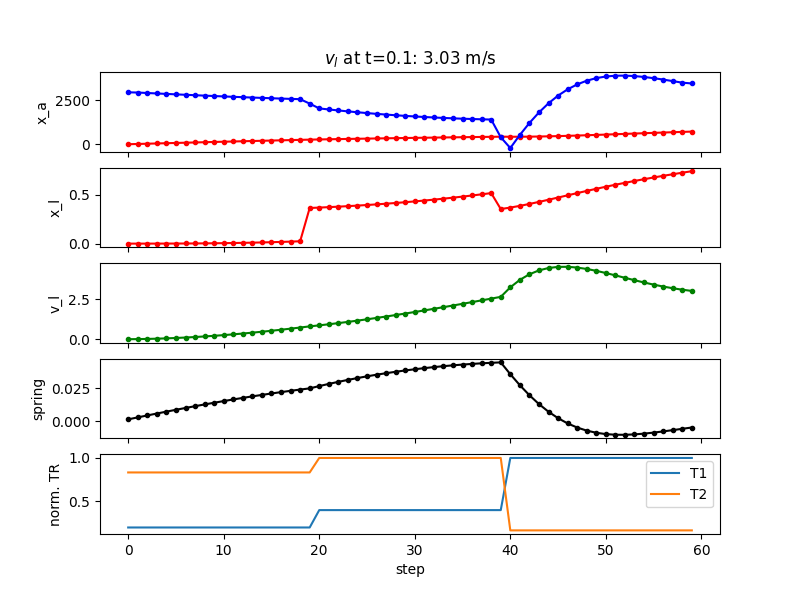

In [22]:
def get_step(X0=[0,0,0], Ts=[0.0003, 20]):
    x_a0, x_l0, v_l0 = X0
    T1, T2 = Ts
    x0 = 1/T2
    x1 = T2**2
    x2 = omega_max**2
    x3 = x1*x2
    x4 = k**2
    x5 = m_l**2
    x6 = T1**4*x5
    x7 = x4*x6
    x9 = 1/tau_max
    x10 = (1/2)*x9
    x12 = T1**2
    x13 = omega_max*t
    x14 = k*x10*x12*x13
    x15 = exp(x14)
    x16 = tau_max*x15
    x17 = x16*x_a0
    x18 = T1*omega_max
    x19 = T2*m_l*v_l0*x18
    x20 = m_l*x12
    x21 = x20*x3
    x22 = k*m_l
    x23 = 2*tau_max
    x24 = x23*x_l0
    x25 = x12*x22
    x26 = x23*x_a0
    x27 = T2*omega_max
    x28 = T2**3
    x29 = omega_max**3
    x30 = T1**3
    x32 = exp(-x14)
    x33 = x32*x9
    x34 = x1*x18
    x35 = T2*v_l0 - x34
    x36 = 2*k
    x37 = T1*T2
    x38 = omega_max*x1
    x39 = 2*v_l0*x25*x38
    x40 = x2*x28
    x41 = x22*x30*x40
    x42 = 2*x41
    x43 = tau_max*x36
    x44 = -x37*x43*x_a0 + x43*x_l0
    r = 4*k*m_l*tau_max**2 - x3*x7
    R_ad_re = sqrt(r) if r > 0 else 0
    R_ad_im = 0 if r>0 else sqrt(-r)
    x11_re = t*x0*x10*R_ad_re/m_l
    x11_im = t*x0*x10*R_ad_im/m_l
    C_os = cos(x11_re)*cosh(x11_im)
    S_in_re = sin(x11_re)*cosh(x11_im)
    S_in_im = cos(x11_re)*sinh(x11_im)
    SdR = (S_in_re*R_ad_re + S_in_im*R_ad_im) / (R_ad_re**2 + R_ad_im**2) # S_in/R_ad should be purely real (aka x31)
    SmR = S_in_re*R_ad_re - S_in_im*R_ad_im  # S_in*R_ad should be purely real
    x_a = x33*(C_os*(-x19 + x21) + x13*x16 + x15*x19 - x15*x21 + x17 + SdR*(-k*v_l0*x3*x30*x5 + k*x28*x29*x6 + x18*x22*x24 - x25*x26*x27))
    x_l = (1/2)*x33*(C_os*(-x39 + x42 + x44) + SmR*x35 + T2*t*x16*x18*x36 + x15*x39 - x15*x42 + x17*x36*x37 + SdR*(T1**5*T2**4*x29*x4*x5 - m_l*x26*x30*x38*x4 - v_l0*x40*x7 + x20*x24*x27*x4))/k
    v_l = x0*x32*(C_os*x35 + x15*x34 + SdR*(k*m_l*omega_max*v_l0*x1*x12 - x41 - x44))

    return [x_a, x_l, v_l]

# Ts_opt = log[-1]
Ts_opt = np.array([
    np.concatenate((np.full(20, 0.0001), np.full(20, 0.0002), np.full(20, 0.0005))),
    np.concatenate((np.full(20, 10), np.full(20, 12), np.full(20, 2))),
    # [10, 12, 2]
])

X = [0,0,0]
log_X = []
log_spring = []
T = Ts_opt[0]
t = 0.005
for i in range(len(Ts_opt[0])):
    
    # X[0] = (T[0]*X[0] + (1/Ts_opt[1,i] - 1/T[1])*X[1]) / Ts_opt[0,i]

    X[1] = Ts_opt[1,i]*((Ts_opt[0,i]-T[0])*X[0] + X[1]/T[1])
    T = Ts_opt[:,i]
    X = get_step(X, T)
    log_X.append(X)

    spring = X[0]*T[0] - X[1]/T[1]
    log_spring.append(spring)
log_X = np.array(log_X)

# print(log_X)

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(8,6))
axs[0].plot(log_X[:,0], 'r.-')
log_X_derivative = np.gradient(log_X[:,0])/t
axs[0].plot(log_X_derivative, 'b.-')

axs[0].set_ylabel('x_a')
axs[1].plot(log_X[:,1], 'r.-')
axs[1].set_ylabel('x_l')
axs[2].plot(log_X[:,2], 'g.-')
axs[2].set_ylabel('v_l')
axs[3].plot(log_spring, 'k.-')
axs[3].set_ylabel('spring')
axs[4].plot(Ts_opt[0,:]/max(Ts_opt[0,:]), label='T1')
axs[4].plot(Ts_opt[1,:]/max(Ts_opt[1,:]), label='T2')
axs[4].legend()
axs[4].set_ylabel('norm. TR')

end_v = log_X[-1,2]
axs[0].set_title(f"$v_l$ at t={t*nsteps}: {round(end_v,2)} m/s")

plt.xlabel("step")
plt.show()